## import copy
import os
import sys
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Import code from src
sys.path.insert(0, '../src/')
import vmc  # noqa

# Set plot and dataframe style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"
params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }

plt.rcParams.update(params)
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

In [9]:
import os 
import sys 
import time

import jax 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from helper import df_to_latex, fig_path, set_figsize, tab_path

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

sys.path.insert(0, '../src/') 
import vmc # noqa

sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large" 
params = {"font.family": "serif", "font.sans-serif": ["Computer Modern"], "axes.labelsize": fontsize, "legend.fontsize": fontsize, "xtick.labelsize": fontsize, "ytick.labelsize": fontsize, "legend.handlelength": 2 }

plt.rcParams.update(params) 
plt.rc('text', usetex=True)

pd.set_option('display.max_columns', 50)

jax.config.update("jax_enable_x64", True) 
jax.config.update('jax_platform_name', 'cpu')

In [2]:
df_rwm = pd.read_csv("../data/sample_ashonib_rwm_all_N.csv")
df_rwm['Algorithm'] = 'RWM'
df_rwm

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,10,3,0.313843,0.01,0.502064,15.000794,0.000782,4.191678e-04,1.500079,0.000782,4.191678e-04,0.254578,65536,120536,9500,45500,0,RWM
1,2,10,3,0.259374,0.01,0.499077,14.999674,0.000376,1.160721e-04,1.499967,0.000376,1.160721e-04,0.366898,65536,119536,7500,46500,0,RWM
2,3,10,3,0.235795,0.01,0.499599,14.999820,0.000192,2.715726e-05,1.499982,0.000192,2.715726e-05,0.413177,65536,115536,6500,43500,0,RWM
3,4,10,3,0.259374,0.01,0.498512,14.999588,0.000705,3.262440e-04,1.499959,0.000705,3.262440e-04,0.355728,65536,113536,9000,39000,0,RWM
4,5,10,3,0.259374,0.01,0.497634,14.997527,0.000943,7.085667e-04,1.499753,0.000943,7.085667e-04,0.360336,65536,115536,7000,43000,0,RWM
5,6,10,3,0.285312,0.01,0.500290,15.000038,0.000119,1.035320e-05,1.500004,0.000119,1.035320e-05,0.304733,65536,123036,7500,50000,0,RWM
6,7,10,3,0.259374,0.01,0.523483,15.036194,0.009603,6.723568e-02,1.503619,0.009603,6.723568e-02,0.338181,65536,85036,7500,12000,0,RWM
7,8,10,3,0.259374,0.01,0.528272,15.025101,0.011650,1.063941e-01,1.502510,0.011650,1.063941e-01,0.339447,65536,85036,7500,12000,0,RWM
8,9,10,3,0.285312,0.01,0.503669,15.002111,0.001661,1.589509e-03,1.500211,0.001661,1.589509e-03,0.305481,65536,109036,8000,35500,0,RWM
9,10,10,3,0.285312,0.01,0.498800,14.999285,0.000470,1.610878e-04,1.499929,0.000470,1.610878e-04,0.302795,65536,120036,7500,47000,0,RWM


In [3]:
df_lmh = pd.read_csv("../data/sample_ashonib_lmh_all_N.csv")
df_lmh['Algorithm'] = 'LMH'
df_lmh

,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm
0,1,10,3,0.885780,0.01,0.493951,15.079684,0.003130,5.199767e-03,1.507968,0.003130,5.199767e-03,0.467957,65536,94036,3500,25000,0,LMH
1,2,10,3,0.732050,0.01,0.498572,15.017165,0.000345,2.302424e-04,1.501717,0.000345,2.302424e-04,0.627335,65536,110036,2500,42000,0,LMH
2,3,10,3,0.605000,0.01,0.499265,15.006797,0.000175,6.533376e-05,1.500680,0.000175,6.533376e-05,0.713318,65536,111536,2000,44000,0,LMH
3,4,10,3,0.605000,0.01,0.502192,14.978617,0.000504,6.279528e-04,1.497862,0.000504,6.279528e-04,0.732620,65536,103036,2000,35500,0,LMH
4,5,10,3,0.732050,0.01,0.500477,14.994515,0.000122,2.569847e-05,1.499451,0.000122,2.569847e-05,0.610535,65536,118036,2500,50000,0,LMH
5,6,10,3,0.885780,0.01,0.500393,14.994867,0.000188,1.948686e-05,1.499487,0.000188,1.948686e-05,0.455719,65536,119536,4000,50000,0,LMH
6,7,10,3,0.732050,0.01,0.500215,14.997601,0.000054,5.400187e-06,1.499760,0.000054,5.400187e-06,0.602921,65536,119036,3500,50000,0,LMH
7,8,10,3,0.885780,0.01,0.503532,14.954342,0.001436,1.600534e-03,1.495434,0.001436,1.600534e-03,0.432861,65536,100536,3500,31500,0,LMH
8,9,10,3,0.885780,0.01,0.498412,15.021696,0.000554,3.027144e-04,1.502170,0.000554,3.027144e-04,0.462097,65536,108536,4000,39000,0,LMH
9,10,10,3,0.732050,0.01,0.500318,14.996353,0.000083,1.221371e-05,1.499635,0.000083,1.221371e-05,0.614777,65536,117036,3500,48000,0,LMH


In [4]:
df = pd.concat([df_rwm, df_lmh], ignore_index=True)
df

,chain_id,nparticles,dim,scale,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,Algorithm,dt
0,1,10,3,0.313843,0.01,0.502064,15.000794,0.000782,0.000419,1.500079,0.000782,0.000419,0.254578,65536,120536,9500,45500,0,RWM,NaN
1,2,10,3,0.259374,0.01,0.499077,14.999674,0.000376,0.000116,1.499967,0.000376,0.000116,0.366898,65536,119536,7500,46500,0,RWM,NaN
2,3,10,3,0.235795,0.01,0.499599,14.999820,0.000192,0.000027,1.499982,0.000192,0.000027,0.413177,65536,115536,6500,43500,0,RWM,NaN
3,4,10,3,0.259374,0.01,0.498512,14.999588,0.000705,0.000326,1.499959,0.000705,0.000326,0.355728,65536,113536,9000,39000,0,RWM,NaN
4,5,10,3,0.259374,0.01,0.497634,14.997527,0.000943,0.000709,1.499753,0.000943,0.000709,0.360336,65536,115536,7000,43000,0,RWM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,12,100,3,NaN,0.01,0.502064,149.926702,0.006521,0.007303,1.499267,0.006521,0.007303,0.436813,65536,116036,9000,41500,0,LMH,0.407014
92,13,100,3,NaN,0.01,0.501155,149.957749,0.002338,0.002356,1.499577,0.002338,0.002356,0.591431,65536,114036,7000,41500,0,LMH,0.336375
93,14,100,3,NaN,0.01,0.501719,149.919198,0.003976,0.004880,1.499192,0.003976,0.004880,0.472824,65536,118536,10000,43000,0,LMH,0.398914
94,15,100,3,NaN,0.01,0.504645,149.800342,0.011234,0.032567,1.498003,0.011234,0.032567,0.430450,65536,108536,7500,35500,0,LMH,0.407014


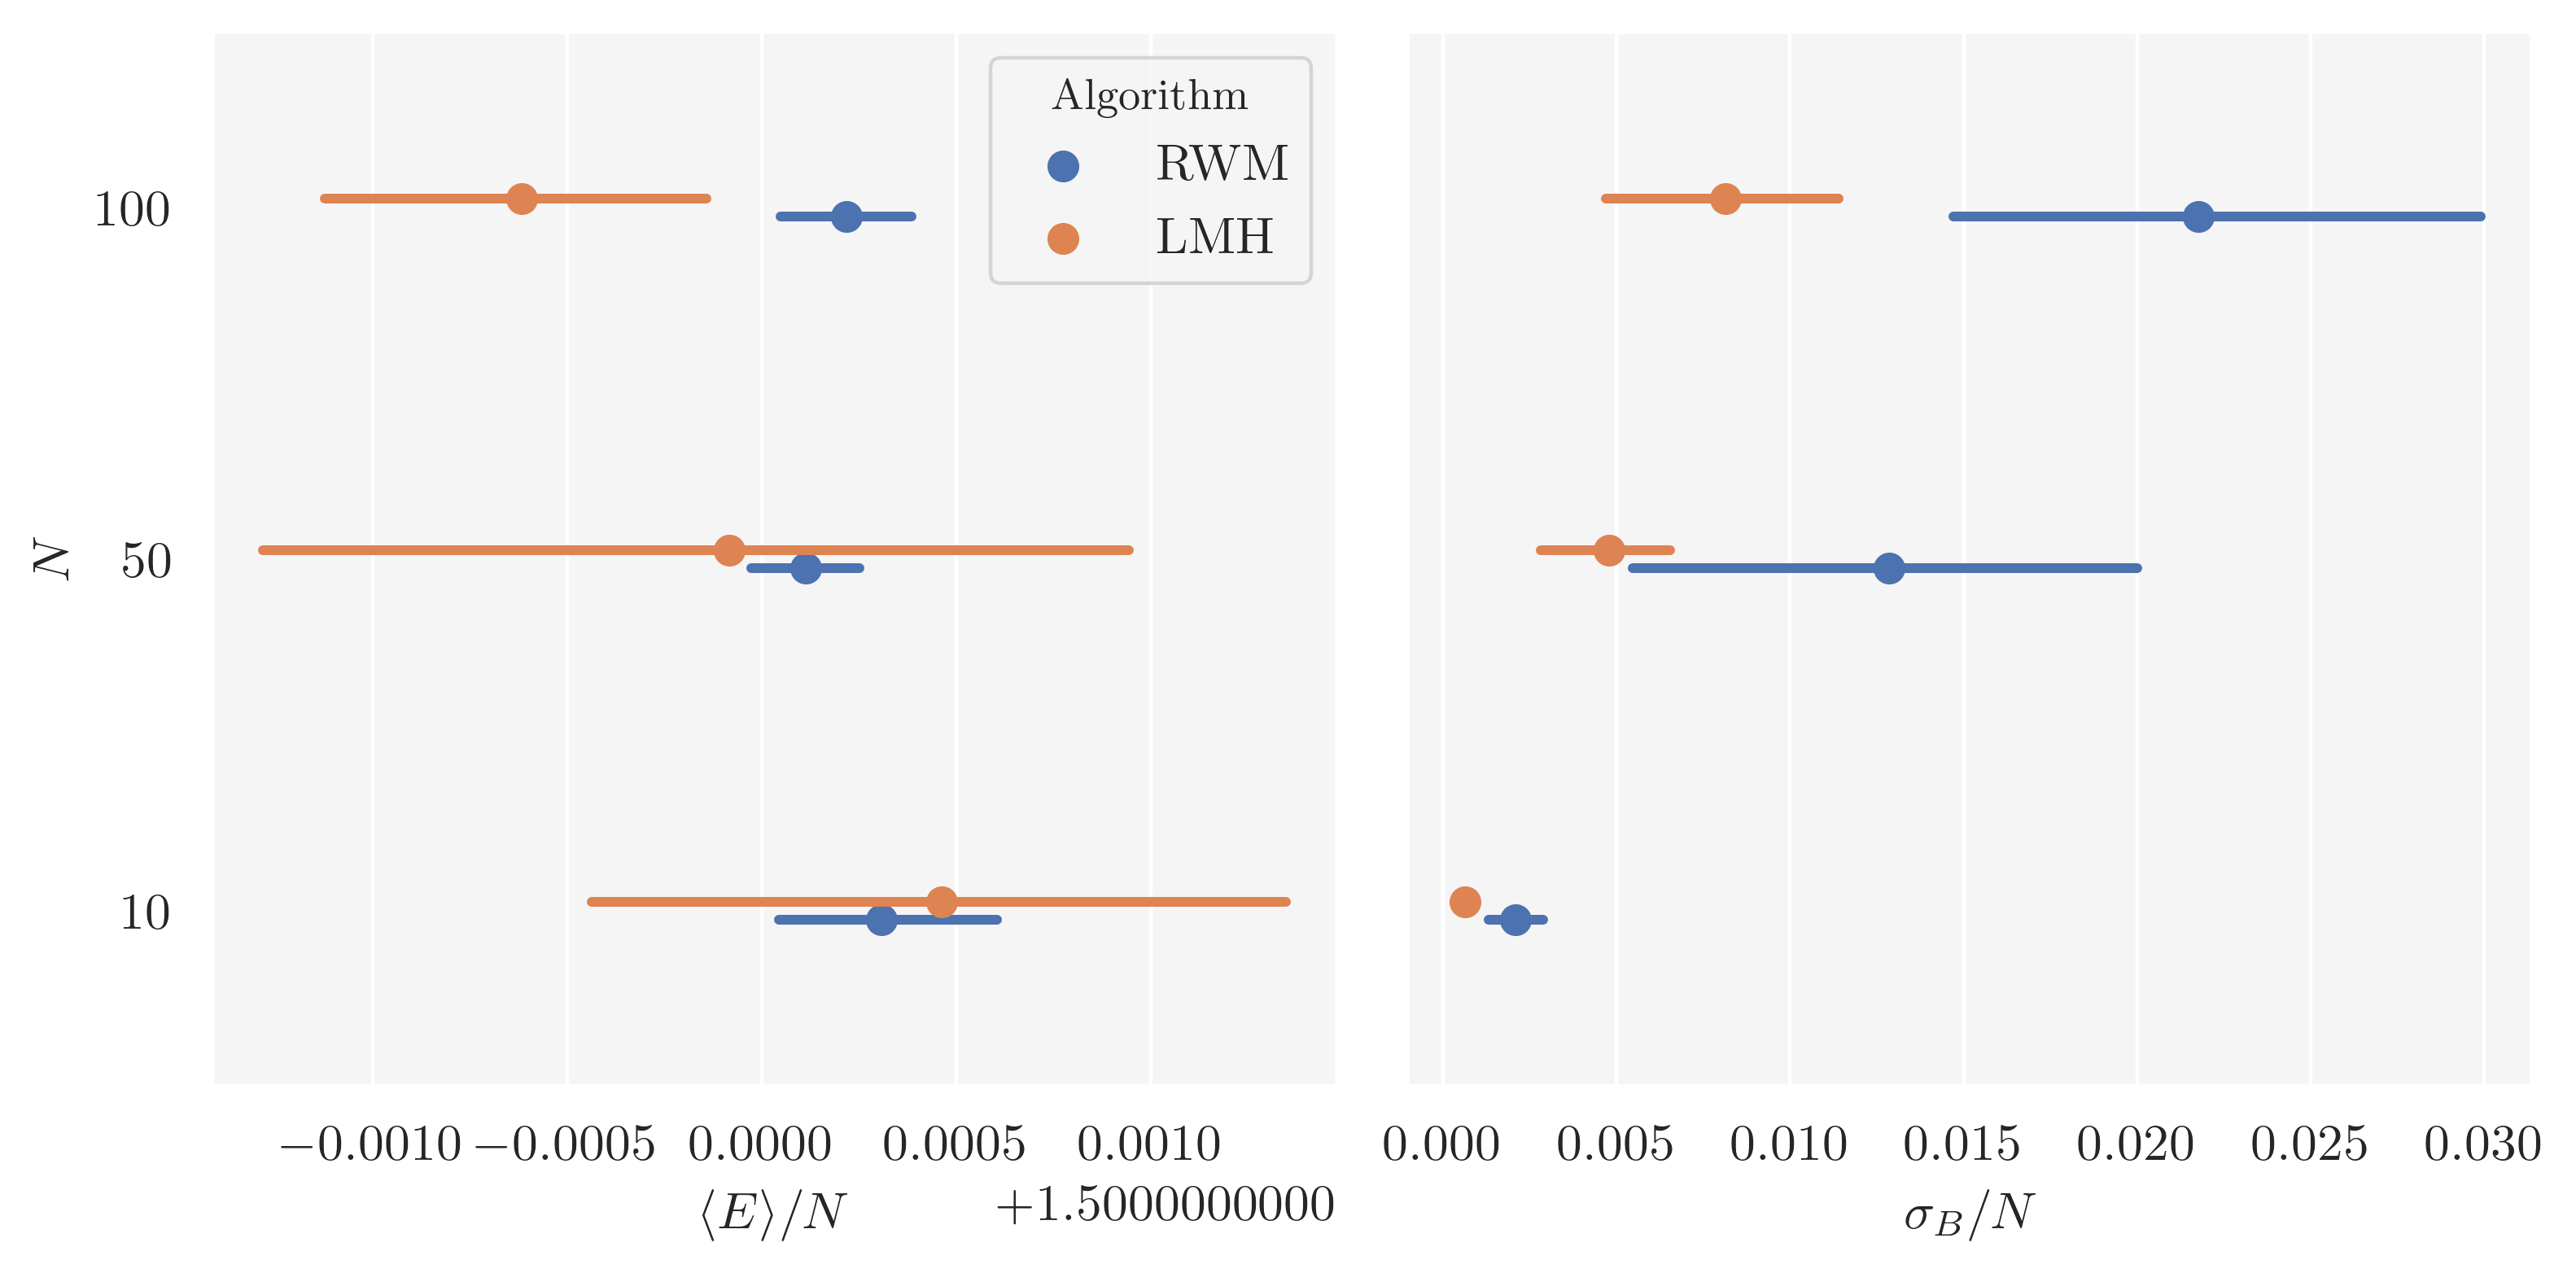

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, tight_layout=True, dpi=200)

sns.pointplot(data=df, 
              x="scaled_energy", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[0]
             )
axes[0].invert_yaxis()
axes[0].set(xlabel=r'$\langle E \rangle / N$', ylabel=r'$N$')

sns.pointplot(data=df, 
              x="scaled_std_error", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[1]
             )
axes[1].invert_yaxis()
axes[1].set(xlabel=r'$\sigma_B / N$', ylabel="")
axes[1].legend().set_visible(False)

fig.savefig(fig_path("energy_ashonib.pdf"), bbox_inches='tight')

In [10]:
df_EI_LMH = pd.read_csv("../data/aehoib_LMH.csv")
print(f"N=10: Mean energy LMH interacting: {np.mean(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==10])} with a \
standard error of the mean: {np.std(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==10])}.")
print(f"N=50: Mean energy LMH interacting: {np.mean(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==50])} with a \
standard error of the mean: {np.std(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==50])}.")
print(f"N=100: Mean energy LMH interacting: {np.mean(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==100])} with a \
standard error of the mean: {np.std(df_EI_LMH['scaled_energy'][df_EI_LMH['nparticles']==100])}.")
#df_EI_LMH2 = df_EI_LMH.groupby(["nparticles"]).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
#df2 = df.groupby(['nparticles', 'alpha'], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df_EI_LMH

N=10: Mean energy LMH interacting: 2.4459448951514204 with a standard error of the mean: 0.0009822656042127377.
N=50: Mean energy LMH interacting: 2.5608819178954887 with a standard error of the mean: 0.0009079234130478744.
N=100: Mean energy LMH interacting: 2.675041856344767 with a standard error of the mean: 0.0013188249023153.


,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles
0,1,10,3,0.146410,0.01,0.497020,24.471656,0.001292,0.005222,2.447166,0.001292,0.005222,0.791595,32768,87768,5000,50000,0
1,2,10,3,0.177156,0.01,0.497380,24.455422,0.001147,0.004361,2.445542,0.001147,0.004361,0.731812,32768,69768,6000,31000,0
2,3,10,3,0.177156,0.01,0.498955,24.448781,0.001664,0.009713,2.444878,0.001664,0.009713,0.728668,32768,89768,7000,50000,0
3,4,10,3,0.177156,0.01,0.496981,24.454917,0.001113,0.004466,2.445492,0.001113,0.004466,0.728088,32768,89768,7000,50000,0
4,1,10,3,0.177156,0.01,0.498549,24.450143,0.001217,0.004088,2.445014,0.001217,0.004088,0.724731,32768,88768,6000,50000,0
5,2,10,3,0.177156,0.01,0.499436,24.446526,0.001418,0.004526,2.444653,0.001418,0.004526,0.728485,32768,89768,7000,50000,0
6,3,10,3,0.177156,0.01,0.497859,24.453426,0.001133,0.004017,2.445343,0.001133,0.004017,0.723969,32768,90768,8000,50000,0
7,4,10,3,0.146410,0.01,0.498001,24.468386,0.001358,0.005029,2.446839,0.001358,0.005029,0.785828,32768,87768,5000,50000,0
8,1,10,3,0.146410,0.01,0.497073,24.473562,0.001322,0.005658,2.447356,0.001322,0.005658,0.790405,32768,87768,5000,50000,0
9,2,10,3,0.177156,0.01,0.499154,24.446883,0.001263,0.004200,2.444688,0.001263,0.004200,0.720215,32768,88768,6000,50000,0


In [11]:
df_EI_LMH2 = df_EI_LMH.groupby(["nparticles"], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df_EI_LMH2

,nparticles,alpha,scaled_energy,scaled_std_error,scaled_variance
0,10,0.498014,2.445945,0.001264,0.004945
1,50,0.492911,2.560882,0.020100,0.345571
2,100,0.489553,2.675042,0.056613,1.602294


In [12]:
df_ENI_LMH = pd.read_csv("../data/aehonib_LMH.csv")
df_ENI_LMH = df_ENI_LMH[48:96]
df_ENI_LMH

,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles
48,1,10,3,0.146410,0.01,0.500000,24.142149,1.427384e-07,2.785328e-11,2.414215,1.427384e-07,2.785328e-11,0.796844,32768,38768,5000,1000,0
49,2,10,3,0.177156,0.01,0.500000,24.142149,1.336970e-07,2.523848e-11,2.414215,1.336970e-07,2.523848e-11,0.729401,32768,39768,6000,1000,0
50,3,10,3,0.177156,0.01,0.500000,24.142149,1.347426e-07,2.501110e-11,2.414215,1.347426e-07,2.501110e-11,0.724335,32768,39768,6000,1000,0
51,4,10,3,0.177156,0.01,0.500000,24.142149,1.206483e-07,2.307843e-11,2.414215,1.206483e-07,2.307843e-11,0.728363,32768,40768,7000,1000,0
52,1,10,3,0.177156,0.01,0.500000,24.142149,1.197945e-07,2.330580e-11,2.414215,1.197945e-07,2.330580e-11,0.727997,32768,39768,6000,1000,0
53,2,10,3,0.177156,0.01,0.500000,24.142149,1.237864e-07,2.285105e-11,2.414215,1.237864e-07,2.285105e-11,0.723511,32768,39768,6000,1000,0
54,3,10,3,0.177156,0.01,0.500000,24.142148,2.453076e-07,9.163159e-11,2.414215,2.453076e-07,9.163159e-11,0.731171,32768,39768,6000,1000,0
55,4,10,3,0.177156,0.01,0.500000,24.142149,1.333074e-07,2.501110e-11,2.414215,1.333074e-07,2.501110e-11,0.728607,32768,41768,8000,1000,0
56,1,10,3,0.146410,0.01,0.500000,24.142149,1.279926e-07,2.467004e-11,2.414215,1.279926e-07,2.467004e-11,0.795776,32768,38768,5000,1000,0
57,2,10,3,0.146410,0.01,0.500000,24.142148,2.653272e-07,9.970336e-11,2.414215,2.653272e-07,9.970336e-11,0.801392,32768,38768,5000,1000,0


In [13]:
df_ENI_LMH2 = df_ENI_LMH.groupby(["nparticles"], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df_ENI_LMH2

,nparticles,alpha,scaled_energy,scaled_std_error,scaled_variance
0,10,0.500000,2.414215,1.664089e-07,4.798295e-11
1,50,0.500151,2.414162,5.312655e-04,1.273551e-03
2,100,0.500125,2.414193,1.631179e-03,1.068981e-03


In [14]:
df_ENI_RWM = pd.read_csv("../data/aehonib_RMW.csv")
df_ENI_RWM = df_ENI_RWM[97:144]
print(f"N=10: Mean energy RWM non-interacting: {np.mean(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==10])} with a \
standard error of the mean: {np.std(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==10])}.")
print(f"N=50: Mean energy RWM non-interacting: {np.mean(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==50])} with a \
standard error of the mean: {np.std(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==50])}.")
print(f"N=100: Mean energy RWM non-interacting: {np.mean(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==100])} with a \
standard error of the mean: {np.std(df_ENI_RWM['scaled_energy'][df_ENI_RWM['nparticles']==100])}.")
df_ENI_RWM

N=10: Mean energy RWM non-interacting: 2.4142149933136974 with a standard error of the mean: 2.403605350975711e-08.
N=50: Mean energy RWM non-interacting: 2.414214942812598 with a standard error of the mean: 6.106487894621024e-07.
N=100: Mean energy RWM non-interacting: 2.4141310283505657 with a standard error of the mean: 0.0003840220220975739.


,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,scale
97,2,10,3,NaN,0.01,0.500000,24.142150,4.682903e-07,8.571988e-11,2.414215,4.682903e-07,8.571988e-11,0.420013,32768,43768,10000,1000,0,0.177156
98,3,10,3,NaN,0.01,0.500000,24.142149,4.363989e-07,8.833467e-11,2.414215,4.363989e-07,8.833467e-11,0.373016,32768,44768,11000,1000,0,0.194872
99,4,10,3,NaN,0.01,0.500000,24.142150,2.587668e-07,2.421530e-11,2.414215,2.587668e-07,2.421530e-11,0.369446,32768,45768,12000,1000,0,0.194872
100,1,10,3,NaN,0.01,0.500000,24.142150,4.572853e-07,8.856205e-11,2.414215,4.572853e-07,8.856205e-11,0.425659,32768,43768,10000,1000,0,0.177156
101,2,10,3,NaN,0.01,0.500000,24.142150,2.059308e-07,2.182787e-11,2.414215,2.059308e-07,2.182787e-11,0.425690,32768,44768,11000,1000,0,0.177156
102,3,10,3,NaN,0.01,0.500000,24.142150,2.340608e-07,2.000888e-11,2.414215,2.340608e-07,2.000888e-11,0.370087,32768,44768,11000,1000,0,0.194872
103,4,10,3,NaN,0.01,0.500000,24.142150,2.289348e-07,2.194156e-11,2.414215,2.289348e-07,2.194156e-11,0.421844,32768,43768,10000,1000,0,0.177156
104,1,10,3,NaN,0.01,0.500000,24.142150,1.347373e-07,5.570655e-12,2.414215,1.347373e-07,5.570655e-12,0.377533,32768,45768,12000,1000,0,0.194872
105,2,10,3,NaN,0.01,0.500000,24.142150,0.000000e+00,-4.547474e-13,2.414215,0.000000e+00,-4.547474e-13,0.376038,32768,44768,11000,1000,0,0.194872
106,3,10,3,NaN,0.01,0.500000,24.142150,3.171833e-07,4.661160e-11,2.414215,3.171833e-07,4.661160e-11,0.372009,32768,46768,13000,1000,0,0.194872


In [15]:
df_ENI_RWM2 = df_ENI_RWM.groupby(["nparticles"], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df_ENI_RWM2

,nparticles,alpha,scaled_energy,scaled_std_error,scaled_variance
0,10,0.500000,2.414215,2.559920e-07,3.836552e-11
1,50,0.499997,2.414215,2.108503e-05,7.458857e-08
2,100,0.500542,2.414131,1.580931e-02,4.063687e-02


In [16]:
df_EI_RWM = pd.read_csv("../data/aehoib_RMW.csv")
df_EI_RWM = df_EI_RWM[144:192]
print(f"N=10: Mean energy RWM interacting: {np.mean(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==10])} with a standard error of the mean: {np.std(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==10])}.")
print(f"N=50: Mean energy RWM interacting: {np.mean(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==50])} with a standard error of the mean: {np.std(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==50])}.")
print(f"N=100: Mean energy RWM interacting: {np.mean(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==100])} with a standard error of the mean: {np.std(df_EI_RWM['scaled_energy'][df_EI_RWM['nparticles']==100])}.")
df_EI_RWM

N=10: Mean energy RWM interacting: 2.4446180887002167 with a standard error of the mean: 0.0005828757941983544.
N=50: Mean energy RWM interacting: 2.5661150768623093 with a standard error of the mean: 0.0042561941647422715.
N=100: Mean energy RWM interacting: 2.694965447319338 with a standard error of the mean: 0.0073835107398851725.


,chain_id,nparticles,dim,dt,eta,alpha,energy,std_error,variance,scaled_energy,scaled_std_error,scaled_variance,accept_rate,nsamples,total_cycles,tuning_cycles,optimize_cycles,warmup_cycles,scale
144,1,10,3,NaN,0.01,0.498448,24.444209,0.002052,0.003860,2.444421,0.002052,0.003860,0.247070,32768,87768,5000,50000,0,0.250000
145,2,10,3,NaN,0.01,0.499875,24.446316,0.002465,0.003910,2.444632,0.002465,0.003910,0.244049,32768,72768,5000,35000,0,0.250000
146,3,10,3,NaN,0.01,0.500660,24.465043,0.002897,0.005835,2.446504,0.002897,0.005835,0.359772,32768,75768,7000,36000,0,0.202500
147,4,10,3,NaN,0.01,0.497086,24.447602,0.003174,0.005896,2.444760,0.003174,0.005896,0.245697,32768,87768,5000,50000,0,0.250000
148,1,10,3,NaN,0.01,0.501237,24.446755,0.002696,0.005089,2.444675,0.002696,0.005089,0.249451,32768,87768,5000,50000,0,0.250000
149,2,10,3,NaN,0.01,0.498374,24.450029,0.002134,0.003992,2.445003,0.002134,0.003992,0.252991,32768,78768,5000,41000,0,0.250000
150,3,10,3,NaN,0.01,0.498981,24.444573,0.002148,0.003961,2.444457,0.002148,0.003961,0.241638,32768,87768,5000,50000,0,0.250000
151,4,10,3,NaN,0.01,0.500570,24.445139,0.002751,0.004303,2.444514,0.002751,0.004303,0.248230,32768,87768,5000,50000,0,0.250000
152,1,10,3,NaN,0.01,0.500231,24.443255,0.002192,0.003825,2.444325,0.002192,0.003825,0.247559,32768,87768,5000,50000,0,0.250000
153,2,10,3,NaN,0.01,0.494488,24.440430,0.003540,0.009121,2.444043,0.003540,0.009121,0.253052,32768,49768,5000,12000,0,0.250000


In [17]:
df_EI_RWM2 = df_EI_RWM.groupby(["nparticles"], as_index=False).mean()[["nparticles", "alpha", "scaled_energy", "scaled_std_error", "scaled_variance"]]
df_EI_RWM2

,nparticles,alpha,scaled_energy,scaled_std_error,scaled_variance
0,10,0.498748,2.444618,0.002567,0.005148
1,50,0.497028,2.566115,0.049530,0.412571
2,100,0.501107,2.694965,0.129690,7.963087


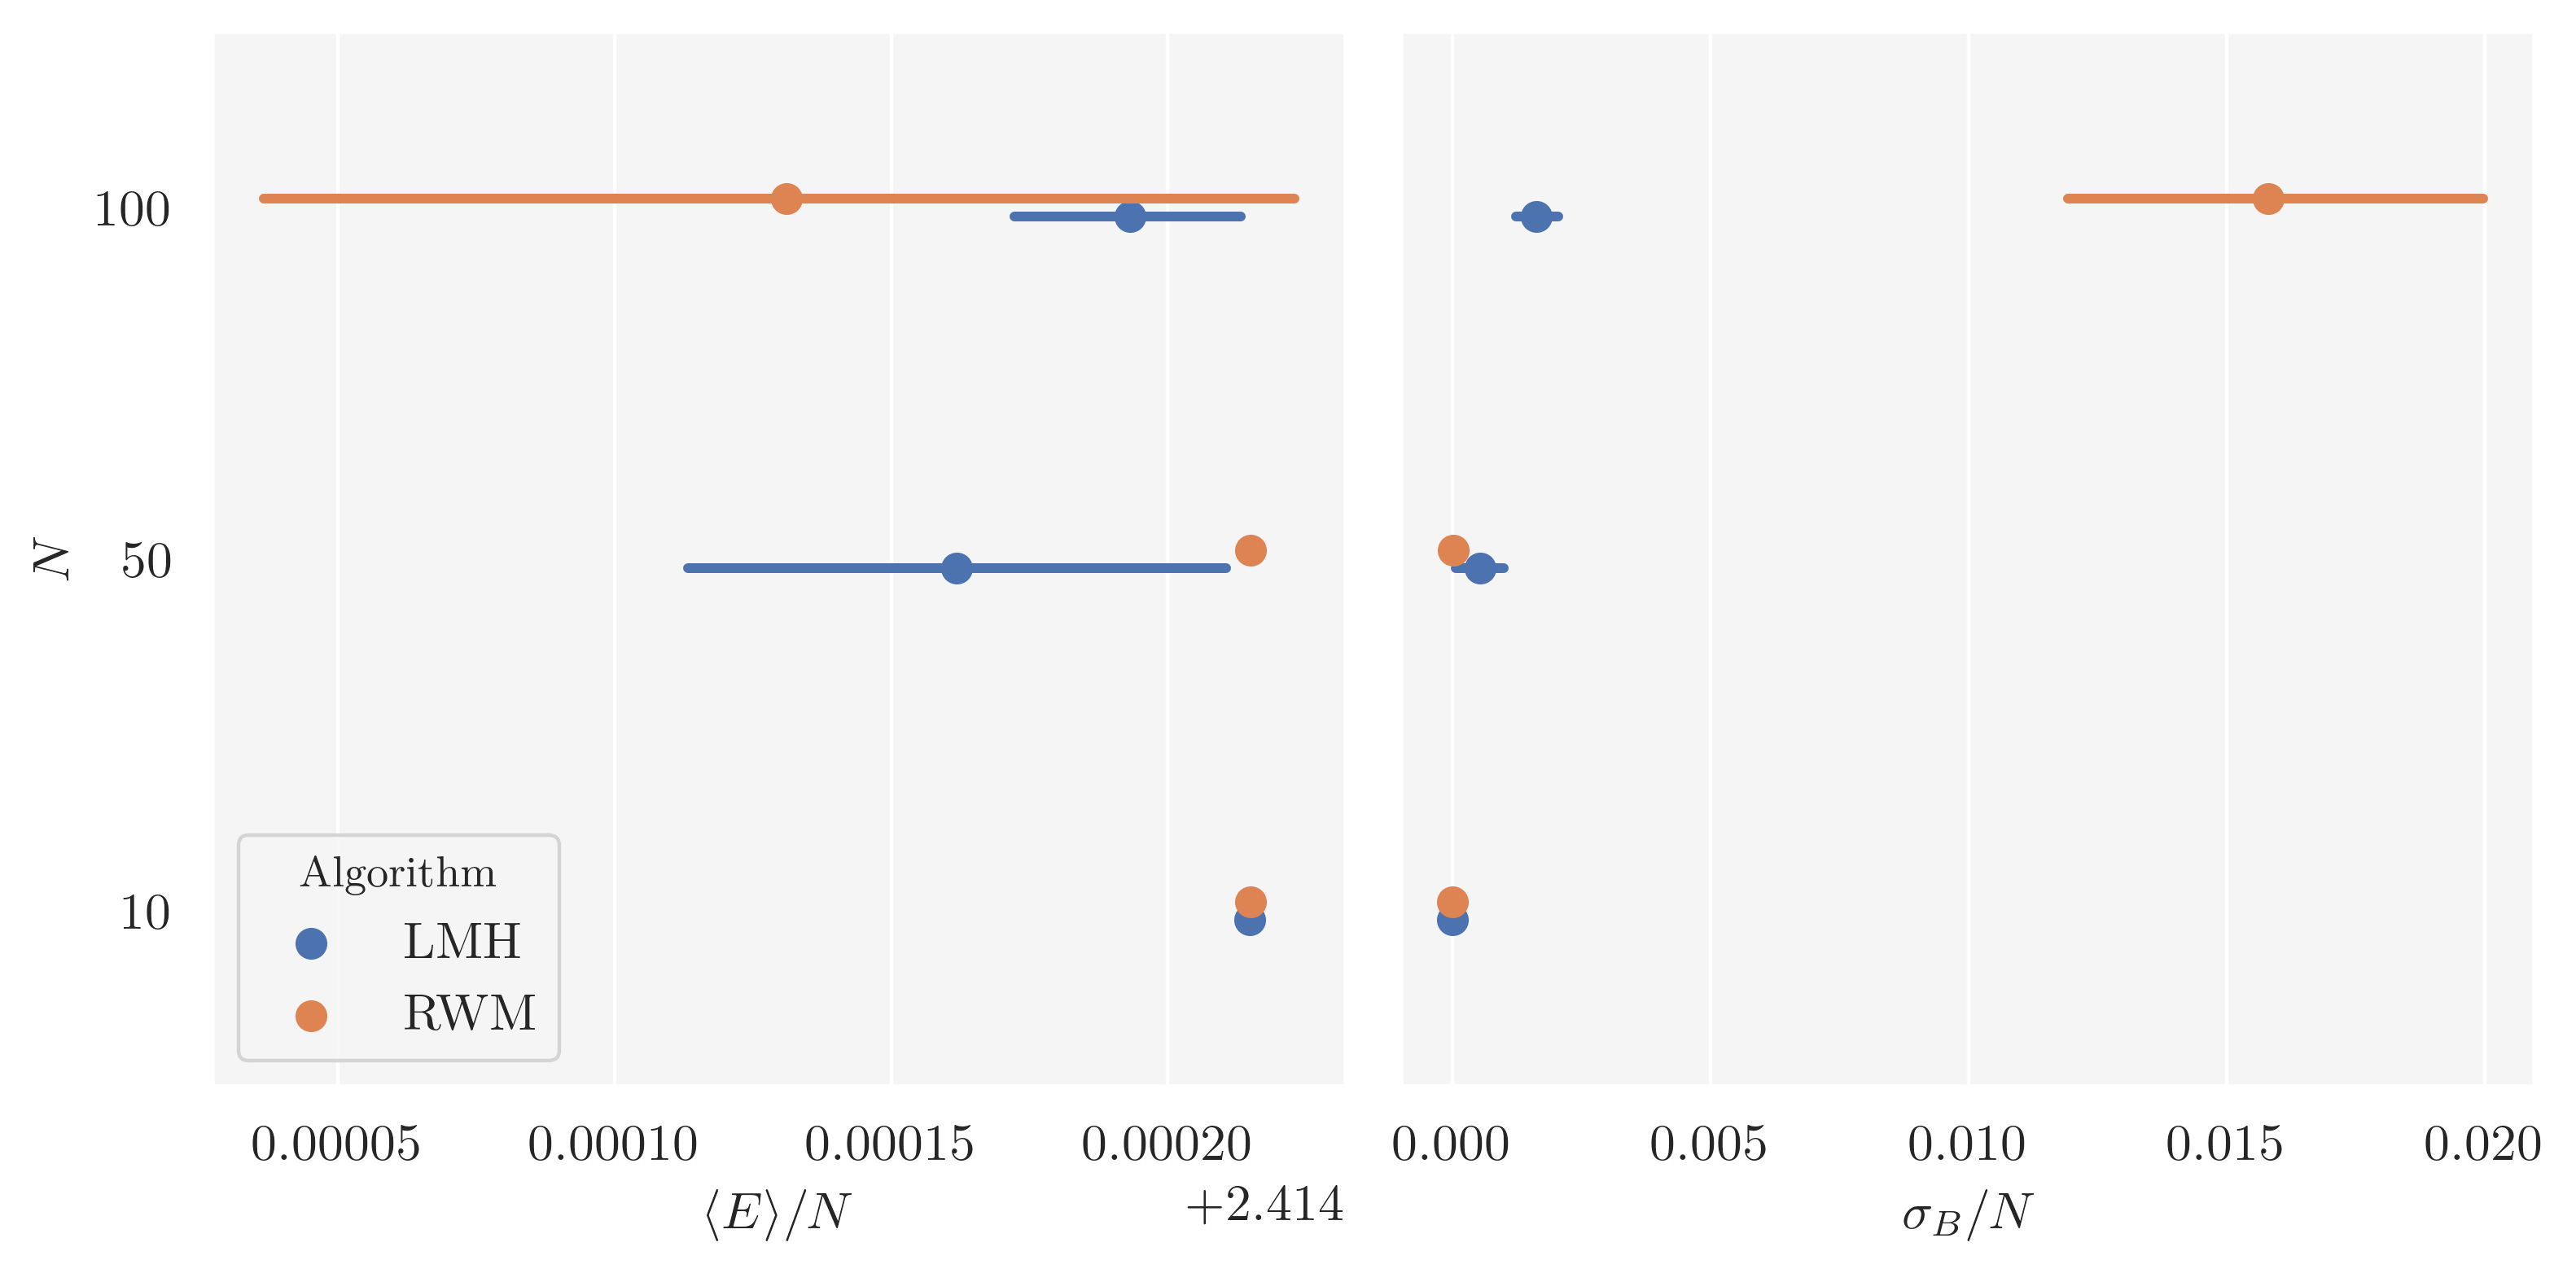

In [18]:
df_EI_LMH["Algorithm"] = "LMH"
df_EI_RWM["Algorithm"] = "RWM"
df_ENI_LMH["Algorithm"] = "LMH"
df_ENI_RWM["Algorithm"] = "RWM"
data_I = pd.concat([df_EI_LMH, df_EI_RWM], ignore_index=True)
data_NI = pd.concat([df_ENI_LMH, df_ENI_RWM], ignore_index=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, tight_layout=True, dpi=200)

sns.pointplot(data=data_NI, 
              x="scaled_energy", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[0]
             )
axes[0].invert_yaxis()
axes[0].set(xlabel=r'$\langle E \rangle / N$', ylabel=r'$N$')

sns.pointplot(data=data_NI, 
              x="scaled_std_error", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[1]
             )
axes[1].invert_yaxis()
axes[1].set(xlabel=r'$\sigma_B / N$', ylabel="")
axes[1].legend().set_visible(False)

fig.savefig(fig_path("non_interacting_elliptical_energies.pdf"), bbox_inches='tight')

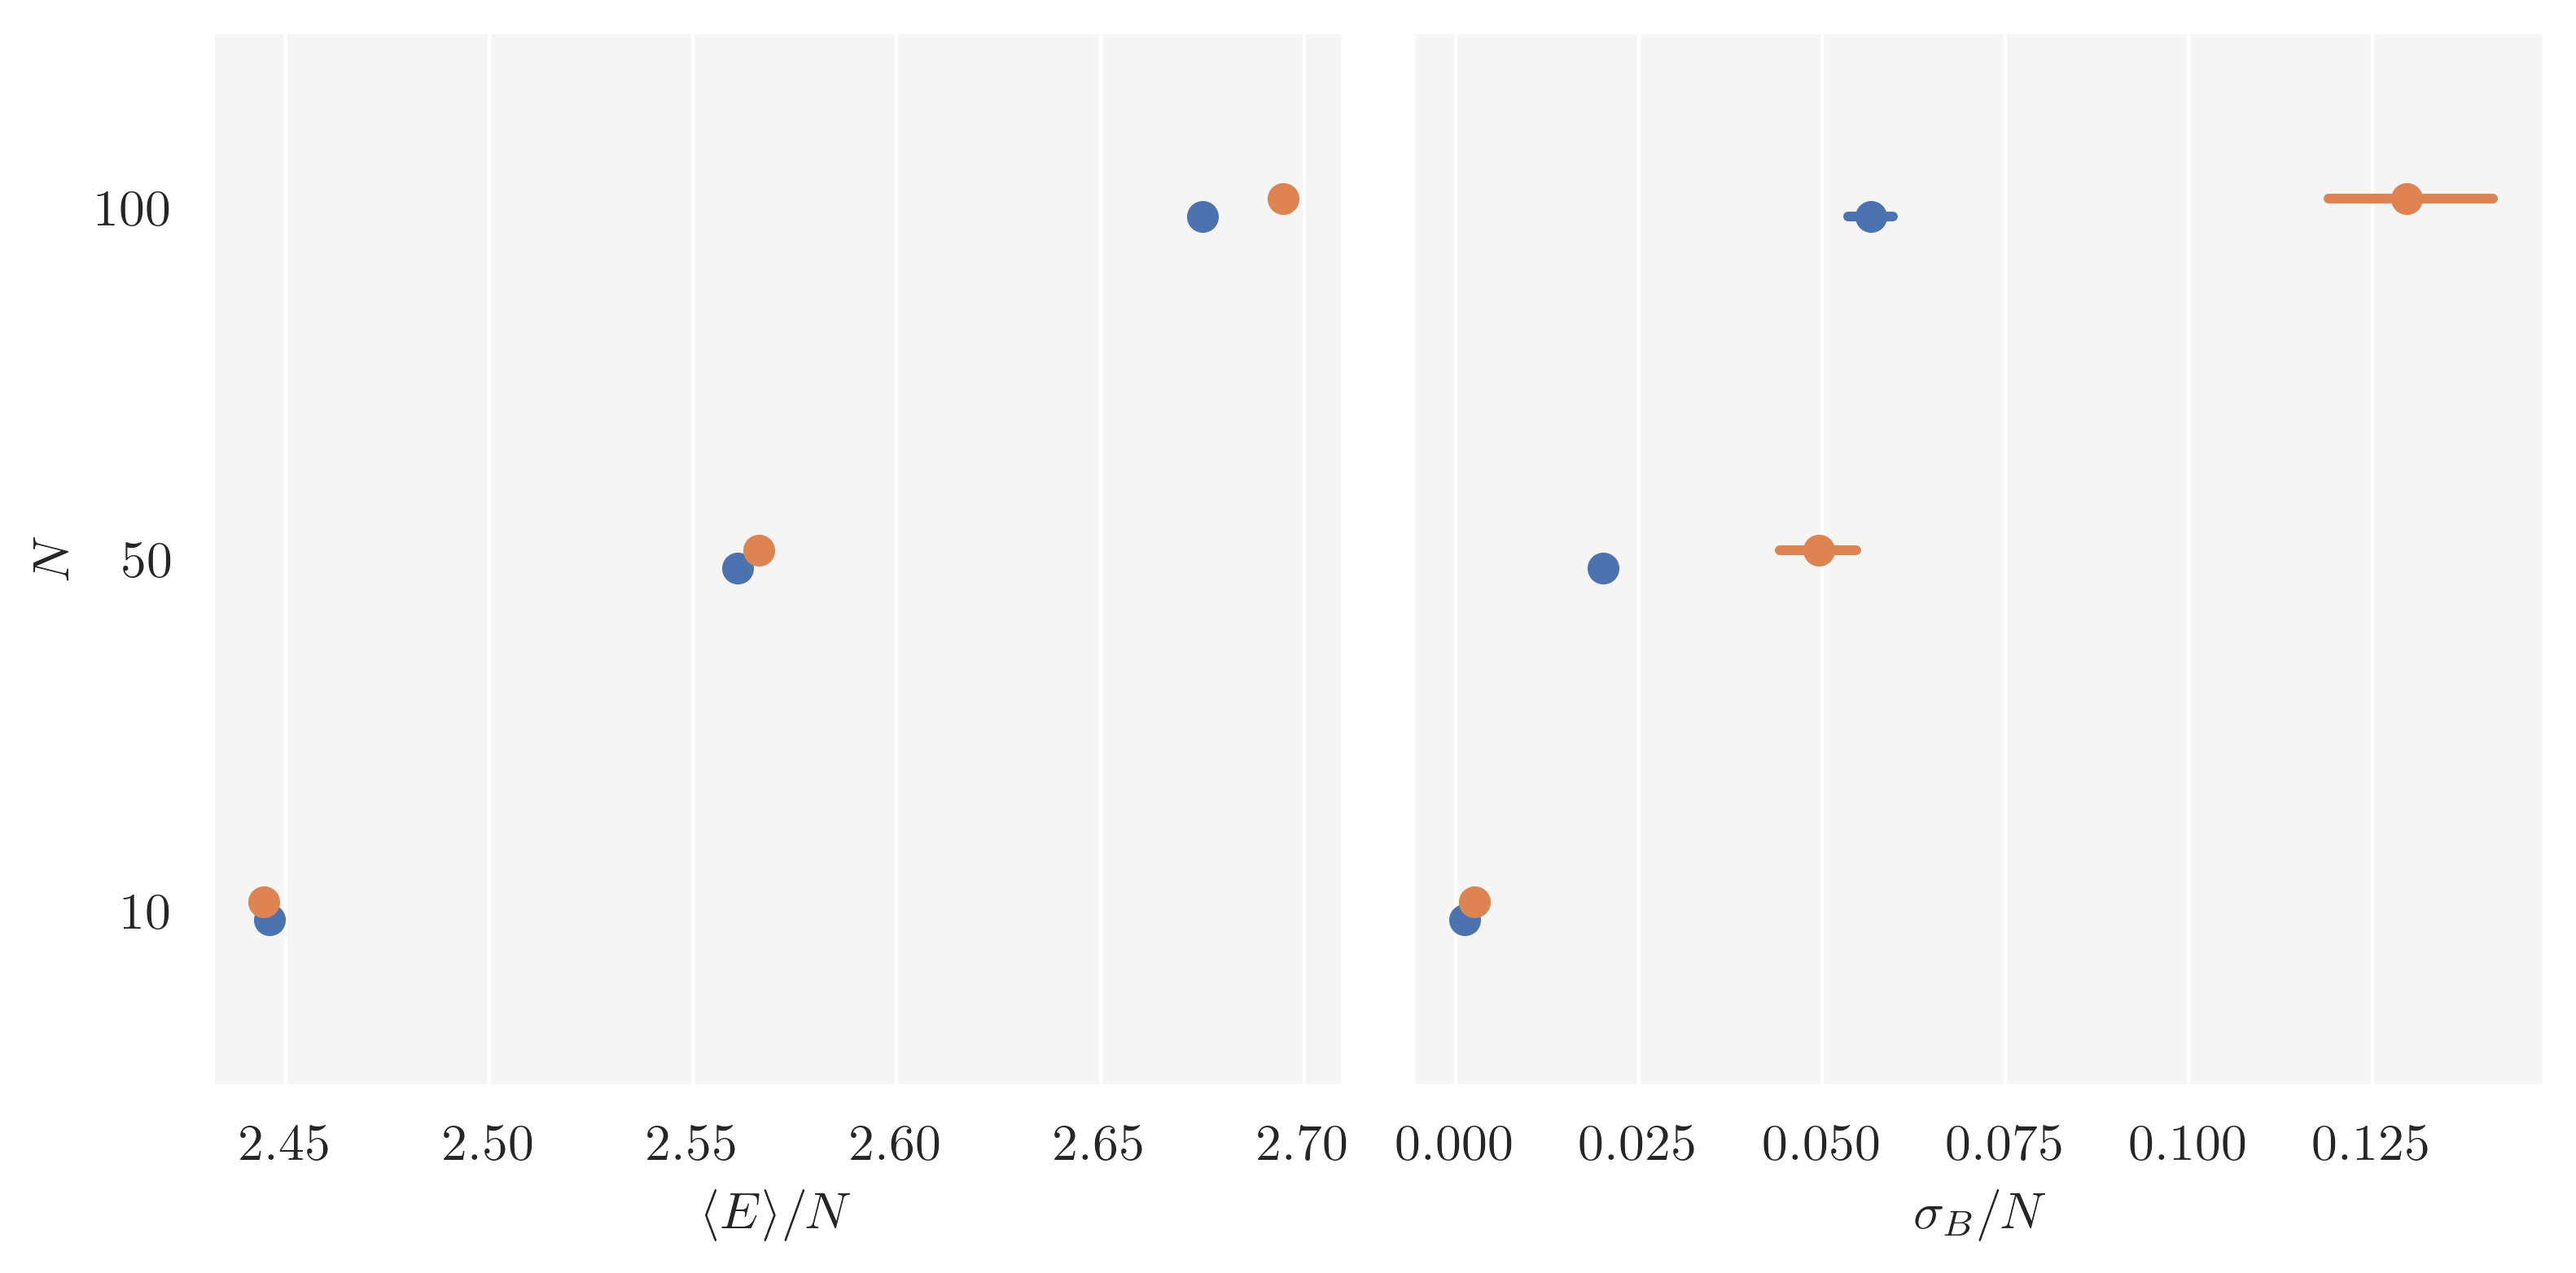

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True, tight_layout=True, dpi=200)

sns.pointplot(data=data_I, 
              x="scaled_energy", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[0]
             )
axes[0].invert_yaxis()
axes[0].set(xlabel=r'$\langle E \rangle / N$', ylabel=r'$N$')
axes[0].legend().set_visible(False)

sns.pointplot(data=data_I, 
              x="scaled_std_error", 
              y="nparticles", 
              hue="Algorithm",
              join=False,
              dodge=True,
              estimator=np.mean,
              ci=68,
              orient="h",
              ax=axes[1]
             )
axes[1].invert_yaxis()
axes[1].set(xlabel=r'$\sigma_B / N$', ylabel="")
axes[1].legend().set_visible(False)

fig.savefig(fig_path("interacting_elliptical_energies.pdf"), bbox_inches='tight')